# Test su SGD con Mini Batch per Kuramoto-Shinomoto-Sakaguchi MV-SDE

In primis importiamo i pacchetti necessari per usare le funzioni matematiche in python.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA
from numpy import mean
from tabulate import tabulate

Scriviamo la MV-SDE relativa al modello di Kuramoto-Shinomoto-Sakaguchi, ovvero:

$$ dX_t = \left( \mathbb{E}[sen(X_t)] cos(X_t) - \mathbb{E}[cos(X_t)] sen(X_t) \right) dt + \sigma dW_t , \ \ \ X_0=x_0. $$

Da questa equazione differenziale si evince che:
* K = 3, d = 1 e q = 1,
* $\varphi(x)=(1, senx, cosx)$, 
* $\alpha(t,x)=(0, cosx, -senx)^T$, 
* $\beta(t,x)=(\sigma, 0 , 0)^T$.

## Metodo di Eulero - Monte Carlo 

In [2]:
def monte_carlo(sigma, T, N, M, X0):
    h = T / N
    X = X0 * np.ones(M)
    gamma1 = np.zeros(N+1)
    gamma2 = np.zeros(N+1)
    gamma1[0] = mean(np.sin(X))
    gamma2[0] = mean(np.cos(X))
    
    for i in range(N):
        W = np.random.normal(0, 1, M) 
        X = X + (gamma1[i] * np.cos(X) - gamma2[i] * np.sin(X)) * h + sigma * math.sqrt(h) * W
        gamma1[i+1] = mean(np.sin(X))
        gamma2[i+1] = mean(np.cos(X))
    
    return X, gamma1, gamma2 

## Metodo di Discesa del Gradiente

### Metodo di Eulero per la Simulazione di $Z(\xi , W)$ e di $\left( Z^a(\tilde{\xi} , \tilde{W}), \partial_{a_{h,j}} Z^a(\tilde{\xi} , \tilde{W}) \right)$

Definiamo le due funzioni che ci permettono di simulare $Z(\xi , W)$ e $\left( Z^a(\tilde{\xi} , \tilde{W}), \partial_{a_{h,j}} Z^a(\tilde{\xi} , \tilde{W}) \right)$, ovvero le soluzioni del sistema dato dalle seguenti equazioni differenziali:

$$ dZ_t = \textbf{h} \left((\mathcal{L}a)(t)\right) \left( \alpha(t, Z_t)dt + \beta(t, Z_t)dW_t\right), \ \ \ Z_0 = \xi.$$

$$ dY^{j,k}_t = g_j(t) \nabla \textbf{h}_k \left((\mathcal{L}a)(t)\right) \left( \alpha(t, Z_t)dt + \beta(t, Z_t)dW_t\right) + \sum_{i=0}^d Y^{j,k,i}_t  \textbf{h} \left((\mathcal{L}a)(t)\right) \left( \partial_{z_i}\alpha(t, Z_t)dt + \partial_{z_i}\beta(t, Z_t)dW_t\right), \ \ \ \ Y^{j,k}_0 = 0,$$

per $j = 0, \cdots , n$ e $k = 1, \cdots, K$.

Ricordiamo che la prima equazione corrisponde alla $(13)$ del articolo e alla $(1.6)$ della mia bozza di tesi, mentre la seconda equazione corrisponde alla $(14)$ dell'articolo e alla $(1.8)$ della mia bozza di tesi. 

Questa funzione serve per creare la base dello spazio dei polinomi. Prende in input la dimensione $n$, il tempo $t$ nella quale i vettori della base devono essere calcolati e la tipologia di base scelta. Restituisce un vettore $n+1$ dimensionale che rappresenta gli elementi della base calcolati in $t$.

* base canonica:   $g_i(t):= t^i$ con nodi equidistanti;
* base di Lagrange: $g_i(t):=\prod_{j \leq n \ e  \ j\neq n} \left( \frac{t - t_j}{t_i - t_j} \right) $ con nodi di Chebyshev: $\frac{a+b}{2} + \frac{b-a}{2} cos \left( \frac{2k + 1}{2n +2} \pi \right)$

In [3]:
def base(T, N, n, X0, tipo):
    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)
    
    if tipo == 'canonica':
        g = np.array([ cc ** i for i in range(n+1)]) 
        
        a1_0 = np.sin(X0) * g[:,0]
        a2_0 = np.cos(X0) * g[:,0]
        
        return a1_0, a2_0, g
    
    elif tipo == 'lagrange':
        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        
        a1_0 = np.sin(X0) * np.ones(n+1) 
        a2_0 = np.cos(X0) * np.ones(n+1) 

        return a1_0, a2_0, g 
        
    
    else:
        return 'err'

In questo algoritmo semplificato le mappe $\textbf{h}$ e $ H $ sono prese rispettivamente come l'identià e la funzione nulla. Riprendendo i valori delle funzioni dei coefficienti per la MV-SDE relativa al modello di Kuramoto-Shninomoto-Sakaguchi si ottiene che nello specifico le equazioni diventano:

$$ dZ_t = \left( (\mathcal{L}a)_1(t) cos(Z_t) - (\mathcal{L}a)_2(t) sen(Z_t) \right) dt + \sigma dW_t, \ \ \ Z_0 = X_0. $$

$$ dY^{j,1}_t = \left( g_j(t) cos(Z_t) - Y^{j,1}_t \left( (\mathcal{L}a)_1(t)sen(Z_t) + (\mathcal{L}a)_2(t)cos(Z_t)\right) \right)dt, \ \ \ Y^{j,1}_0 = 0,$$

$$ dY^{j,2}_t = \left( -g_j(t) sen(Z_t) - Y^{j,2}_t \left( (\mathcal{L}a)_1(t)sen(Z_t) + (\mathcal{L}a)_2(t)cos(Z_t)\right) \right)dt, \ \ \ Y^{j,2}_0 = 0,$$
per $j = 0, \cdots , n$.

In [4]:
def eulero(a1, a2, sigma, n, N, M, Z0, h, g):
    
    X = Z0 * np.ones((N+1, M))
    Z = Z0 * np.ones((N+1, M))
    Y1 = np.zeros((N+1, n+1, M))
    Y2 = np.zeros((N+1, n+1, M))
    
    for i in range(N):
        c1 = np.dot(a1, g[:,i])
        c2 = np.dot(a2, g[:,i])
        
        W = np.random.normal(0, 1, (2, M)) 
    
        X[i+1] = X[i] + (c1 * np.cos(X[i]) - c2 * np.sin(X[i])) * h + sigma * math.sqrt(h) * W[0] 

        Y1[i+1] = Y1[i] + ((g[:,i] * np.ones((M, 1))).transpose() * np.cos(Z[i]) - Y1[i] * (c1 * np.sin(Z[i]) + c2 * np.cos(Z[i]))) * h
        Y2[i+1] = Y2[i] + ((-g[:,i] * np.ones((M, 1))).transpose() * np.sin(Z[i]) - Y2[i] * (c1 * np.sin(Z[i]) + c2 * np.cos(Z[i]))) * h

        Z[i+1] = Z[i] + (c1 * np.cos(Z[i]) - c2 * np.sin(Z[i])) * h + sigma * math.sqrt(h) * W[1]
        
    
    return X, Z, Y1, Y2

### Metodo di Discesa 

In questa sezione ci sono le due funzioni cardine del codice. La prima serve a calcolare la realizzazione del gradiente per la discesa stocastica, ovvero la funzione $v$ descritta nella (17) dell'articolo. In generale la scrittura di $v$, componente per componente, è la seguente:

$$v_{j,k}(a; \xi, W; \tilde{\xi}, \tilde{W}) = 2 \int_0^T \langle \varphi (Z^a_t(\xi,W)) - \textbf{h} ((\mathcal{L}a)(t)), \nabla_x \varphi (Z^a_t(\tilde{\xi}, \tilde{W})) Y_t^{a;j,k}(\tilde{\xi}, \tilde{W}) - \partial_{a_{j,k}}\textbf{h}((\mathcal{L}a)(t))\rangle dt, $$ 
con $j = 0, \cdots , n$ e $k = 1, \cdots, K$.

Come nei casi precedenti scriviamo questa e quazione nel caso specifico del nostro algoritmo. Avendo suddiviso il tempo in N steps temporali, approssimiamo l'integrale con una sommatoria.

$$v_{j,1}(a; W; \tilde{W}) = 2 h \sum_{t=0}^{N} \left[ \left( sen(Z^a_t(W)) - (\mathcal{L}a)_1(t) \right) \cdot \left( cos(Z^a_t(\tilde{W})) Y_t^{a;j,1}(\tilde{W}) - g_j(t) \right) + \left( cos(Z^a_t(W)) - (\mathcal{L}a)_2(t) \right) \cdot \left( -sen(Z^a_t(\tilde{W})) Y_t^{a;j,1}(\tilde{W}) \right)\right], $$ 

$$v_{j,2}(a; W; \tilde{W}) = 2 h \sum_{t=0}^{N} \left[ \left( sen(Z^a_t(W)) - (\mathcal{L}a)_1(t) \right) \cdot \left( cos(Z^a_t(\tilde{W})) Y_t^{a;j,2}(\tilde{W}) \right) + \left( cos(Z^a_t(W)) - (\mathcal{L}a)_2(t) \right) \cdot \left( -sen(Z^a_t(\tilde{W})) Y_t^{a;j,2}(\tilde{W}) - g_j(t) \right)\right], $$  
con $j = 0, \cdots , n$.

Notiamo che prima di restituire il valore $v$ questa fuzione fa una media. Esso serve nel caso $M>1$ in cui sfruttiamo molteplici simulzioni del browniano per aver una miglior stima di $v$.

In [5]:
def discesa_stocastica_del_gradiente(a1_0, a2_0, n, r0, rho, sigma, N, M, X0, eps, h, g, gamma1, gamma2):
    a1 = a1_0 
    a2 = a2_0

    norma1 = LA.norm(gamma1)
    norma2 = LA.norm(gamma2)
    
    for m in range(50000):
        
        if (m % 10 == 0):
            if ( ((LA.norm(np.dot(a1,g) - gamma1)/ norma1) < eps) and ((LA.norm(np.dot(a2,g) - gamma2)/ norma2) < eps) ):
                break
            
        eta = r0 / ((m + 1) ** rho) 
        
        Z, Ztilde, Y1tilde, Y2tilde = eulero(a1, a2, sigma, n, N, M, X0, h, g)
        
        
        v1 = np.zeros(n+1)
        v2 = np.zeros(n+1)
        
        for j in range(n+1): 

            v1[j] = mean( 2 * h * sum( (np.sin(Z) - (np.dot(a1,g) * np.ones((M, 1))).transpose()) \
                                      * (np.cos(Ztilde) * Y1tilde[:,j] - (g[j,:] * np.ones((M, 1))).transpose()) \
                                      + (np.cos(Z) - (np.dot(a2,g) * np.ones((M, 1))).transpose()) \
                                      * (-np.sin(Ztilde) * Y1tilde[:,j]) ) ) 
        
            v2[j] = mean( 2 * h * sum( (np.sin(Z) - (np.dot(a1,g) * np.ones((M, 1))).transpose()) \
                                      * (np.cos(Ztilde) * Y2tilde[:,j]) \
                                      + (np.cos(Z) - (np.dot(a2,g) * np.ones((M, 1))).transpose()) \
                                      * (-np.sin(Ztilde) * Y2tilde[:,j] - (g[j,:] * np.ones((M, 1))).transpose()) ) )
        
        a1 = a1 - eta * v1
        a2 = a2 - eta * v2
        
    return a1, a2, m

## Main

Concludiamo riportando il main che richiama le funzioni sopra definite. Ricordiamo a cosa corrisponderanno i valori che daremo in input alle funzioni che richiameremo:
* N : numero di iterazioni (steps temporali),
* M : numero di simulazioni in ogni istante,
* T : istante finale,
* $\mu$ : funzione di Drift,
* $\sigma$ : funzione di Diffuzione,
* h : step temporale,
* $X_0$ : dato iniziale.

Richiameremo inoltre:
* n: dimensione dello spazio dei polinomi,
* $a_0$: valore iniziale del vettore del metodo SGD. Ora è semplificata, poi ci mettiamo lo sviluppo di Taylor di Kolmogorov di gamma1+gamma2,
* $r_0$ e $\rho$: servono per i learning rates e devono essere  $r_0 \in (0, +\infty)$ e $\frac{1}{2} < \rho \leq 1$ ,
* m: num di step per il mtodo SGD,
* M: mini batch tra SGD e GD,
* $\epsilon$: tolleranza errore relativo dell' 1%,
* k: numero di iterazioni successive che devono essere minori di $\epsilon$ per fermare il ciclo.

In [7]:
if __name__ == "__main__":
    
    # Parametri variabili
    
    T = 2   # 0.5, 1, 2, 4
    n = 3  # 3, 4, 5, 6  
    M = 1   # 1, 10, 100, 1000, 10000  #ricorda per gli ultimi due di togliere m % 10
    

    
    # Parametri fissi
    
    sigma = 0.5
    N = 100
    X0 = 0.5
    
    N1 = 100   # 1000
    M1 = 1000000
    
    h = T / N  
    r0 = [10]
    rho = [0.6, 0.7, 0.8, 0.9]
    eps = 0.01
    p = 10 
    tipo = 'lagrange'

        
    # Eulero Monte Carlo
    
    start = time.process_time()   # parte il cronometro
    X, Gamma1, Gamma2 = monte_carlo(sigma, T, N1, M1, X0)
    end = time.process_time()   # si ferma il cronometro
    
    print("Tempo di esecuzione Eulero - Monte Carlo: ", end - start)
    print(" ")
    
    gamma1 = np.array(Gamma1)
    gamma2 = np.array(Gamma2)
    
    # gamma1 = np.array([Gamma1[i] for i in range(0, len(Gamma1), int(N1/N))])
    # gamma2 = np.array([Gamma2[i] for i in range(0, len(Gamma2), int(N1/N))])
    
    
    # Discesa del Gradiente
    
    A1 = []
    A2 = []
    
    a1_0, a2_0, g = base(T, N, n, X0, tipo)
    m = np.zeros((len(rho), len(r0)*3+1))
    m[:,0] = rho
    
    
    print("Numero m di step per avere convergenza con M = "+str(M)+" :")
    print(" ")

    for i in range(len(r0)):
        for j in range(len(rho)):
            mm = [0] * p
            start = time.process_time()   # parte il cronometro 
            for k in range(p):
                AA1, AA2, mm[k] = discesa_stocastica_del_gradiente(a1_0, a2_0, n, r0[i], rho[j], sigma, N, M, X0, eps, h, g, gamma1, gamma2) 
            
            m[j,3*i+1:3*i+4] = [min(mm), max(mm), mean(mm)]
            end = time.process_time()   # si ferma il cronometro 
        
            A1.append(AA1)
            A2.append(AA2)       
            print("Tempo di esecuzione con r0="+str(r0[i])+" e rho="+str(rho[j])+": ", (end - start) / p )
            # print("Numero di step con r0="+str(r0[i])+" e rho="+str(rho[j])+": ", m[j,i+1])


    l = ["rho \ r0"]
    for i in range(len(r0)):
        l.append(" ")
        l.append(str(r0[i]))
        l.append(" ")
    print(" ")
    print(tabulate(m[:,:], headers=l))
    print(" ")
    print(" ")

Tempo di esecuzione Eulero - Monte Carlo:  26.578125
 
Numero m di step per avere convergenza con M = 1 :
 


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10836\3650935550.py:16: RuntimeWarning: overflow encountered in multiply
  Y1[i+1] = Y1[i] + ((g[:,i] * np.ones((M, 1))).transpose() * np.cos(Z[i]) - Y1[i] * (c1 * np.sin(Z[i]) + c2 * np.cos(Z[i]))) * h
C:\Users\Andrea\AppData\Local\Temp\ipykernel_10836\3650935550.py:17: RuntimeWarning: overflow encountered in multiply
  Y2[i+1] = Y2[i] + ((-g[:,i] * np.ones((M, 1))).transpose() * np.sin(Z[i]) - Y2[i] * (c1 * np.sin(Z[i]) + c2 * np.cos(Z[i]))) * h
C:\Users\Andrea\AppData\Local\Temp\ipykernel_10836\3650935550.py:16: RuntimeWarning: invalid value encountered in add
  Y1[i+1] = Y1[i] + ((g[:,i] * np.ones((M, 1))).transpose() * np.cos(Z[i]) - Y1[i] * (c1 * np.sin(Z[i]) + c2 * np.cos(Z[i]))) * h
C:\Users\Andrea\AppData\Local\Temp\ipykernel_10836\3650935550.py:17: RuntimeWarning: invalid value encountered in add
  Y2[i+1] = Y2[i] + ((-g[:,i] * np.ones((M, 1))).transpose() * np.sin(Z[i]) - Y2[i] * (c1 * np.sin(Z[i]) + c2 * np.cos(Z[i]))) * h
C:\Use

KeyboardInterrupt: 

Grafico dell'approssimazione di $\mathbb{E}[sen(X)]$.

In [ ]:
fig = plt.figure() 
plt.title("Confronto MC [" + str(M1) + " simulazioni] e SGD") 
plt.xlabel("Step temporali") 
plt.ylabel("Evoluzione di E[sen(X)]") 
plt.ylim(0.4, 0.6) # se non c'è il grafico è molto zoomato
plt.plot(np.dot(A1[0], g), label='(La)1(t)')
plt.plot(gamma1, label='gamma1')
plt.legend()
plt.show() 

Grafico dell'approssimazione di $\mathbb{E}[cos(X)]$.

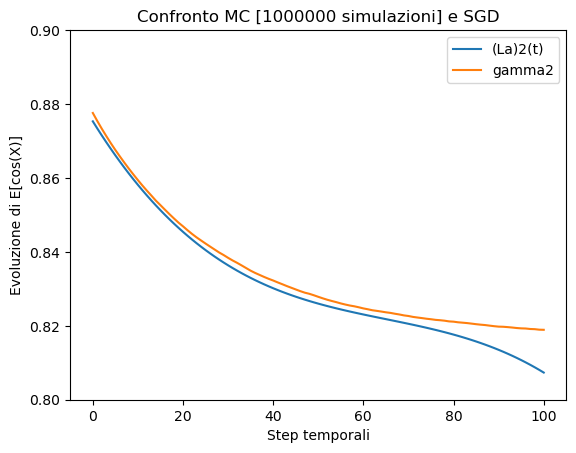

In [22]:
fig = plt.figure() 
plt.title("Confronto MC [" + str(M1) + " simulazioni] e SGD") 
plt.xlabel("Step temporali") 
plt.ylabel("Evoluzione di E[cos(X)]") 
plt.ylim(0.8, 0.9) # se non c'è il grafico è molto zoomato
plt.plot(np.dot(A2[0], g), label='(La)2(t)')
plt.plot(gamma2, label='gamma2')
plt.legend()
plt.show() 